#📌**Step 1: Import Libraries**

In [ ]:
# Import necessary libraries
from google.colab import drive
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#**📌 Step 2: Load Dataset & EDA (Exploratory Data Analysis)**

**Check Number of Images Per Class**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-22-ba4b1a079a08>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df, palette="viridis")


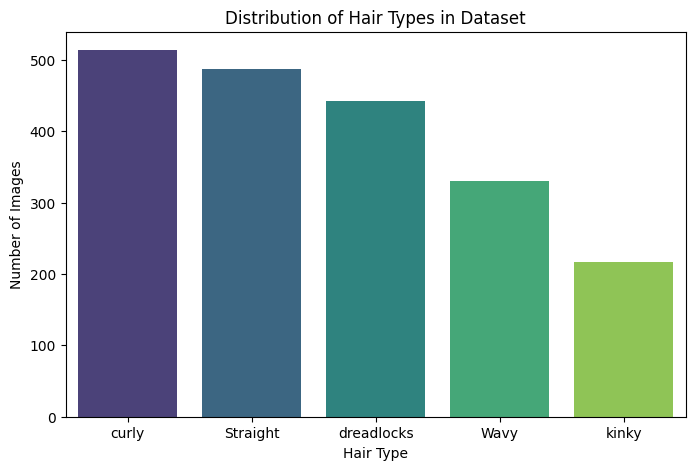

In [ ]:
# Define dataset directory
dataset_path = "/content/drive/MyDrive/hair_dataset"
# Count images per class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        class_counts[class_name] = len(os.listdir(class_dir))

# Convert to DataFrame for easy visualization
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
df = df.sort_values(by="Count", ascending=False)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.barplot(x="Class", y="Count", data=df, palette="viridis")
plt.title("Distribution of Hair Types in Dataset")
plt.xlabel("Hair Type")
plt.ylabel("Number of Images")
plt.show()

**2️⃣ Display Sample Images**

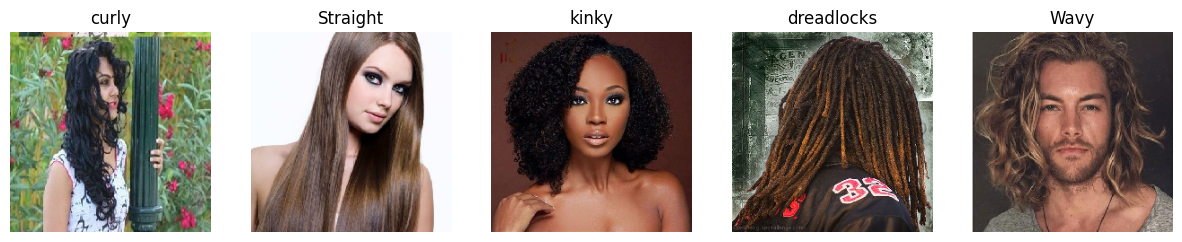

In [ ]:
import random

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for idx, class_name in enumerate(class_counts.keys()):
    class_path = os.path.join(dataset_path, class_name)
    img_file = random.choice(os.listdir(class_path))
    img = load_img(os.path.join(class_path, img_file), target_size=(224, 224))

    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis("off")

plt.show()

#**📌 Step 3: Data Preprocessing**

**Define Constants and Create DataFrame**

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

data = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for img in os.listdir(class_dir):
            data.append({"filename": os.path.join(class_name, img), "Class": class_name})
df = pd.DataFrame(data)

**Stratified Data Splitting**

In [ ]:
#train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["Class"], random_state=42)
#val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["Class"], random_state=42)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Class"], random_state=42)

In [ ]:
train_df.head(10)

,filename,Class
187,curly/image16.jpg,curly
115,curly/curl-tips-styling-1561743013.jpg,curly
569,Straight/8-centreparted-layered-cut-for-long-h...,Straight
1176,kinky/image44.jpg,kinky
1858,Wavy/images (3).jpg,Wavy
1917,Wavy/images5.jpg,Wavy
1537,dreadlocks/image49.jpg,dreadlocks
307,curly/image31.jpg,curly
466,curly/images47.jpg,curly
1026,kinky/011b913aca7afbdd7feb6cdd4481b3bf4.jpg,kinky


**Display Class Shapes After Splitting**

Number of Samples per Class After Splitting:
            Training  Test  Total
Class                            
Straight         390    98    488
Wavy             264    66    330
curly            411   103    514
dreadlocks       354    89    443
kinky            174    43    217


<Figure size 1000x600 with 0 Axes>

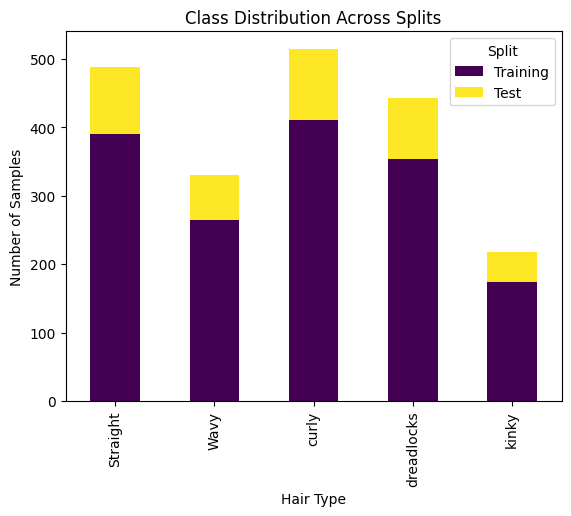

In [ ]:
# Count samples per class in each split
train_counts = train_df['Class'].value_counts().sort_index()
test_counts = test_df['Class'].value_counts().sort_index()

# Combine counts into a single DataFrame for display
split_counts = pd.DataFrame({
    'Training': train_counts,
    'Test': test_counts
}).fillna(0).astype(int)  # Fill NaN with 0 and convert to int

# Add total counts for reference
split_counts['Total'] = split_counts['Training'] + split_counts['Test']

# Display the table
print("Number of Samples per Class After Splitting:")
print(split_counts)

# Optional: Visualize the split distribution
plt.figure(figsize=(10, 6))
split_counts[['Training','Test']].plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Class Distribution Across Splits")
plt.xlabel("Hair Type")
plt.ylabel("Number of Samples")
plt.legend(title="Split")
plt.show()

**Define Data Generators**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

**Setup Data Generators**

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=dataset_path,
    x_col="filename",
    y_col="Class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=dataset_path,
    x_col="filename",
    y_col="Class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

Found 1588 validated image filenames belonging to 5 classes.
Found 399 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


#**📌 Step 5: Handle Class Imbalance**

In [ ]:
# Extract class labels
y_train = train_generator.classes  # Get labels for training set
class_labels = list(train_generator.class_indices.keys())

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print("Class Indices:", train_generator.class_indices)
print("Class Weights:", class_weight_dict)

Class Indices: {'Straight': 0, 'Wavy': 1, 'curly': 2, 'dreadlocks': 3, 'kinky': 4}
Class Weights: {0: 0.820671834625323, 1: 1.2076045627376426, 2: 0.7746341463414634, 3: 0.8971751412429378, 4: 1.825287356321839}


#**📌 Step 6: Final Preprocessing Check**

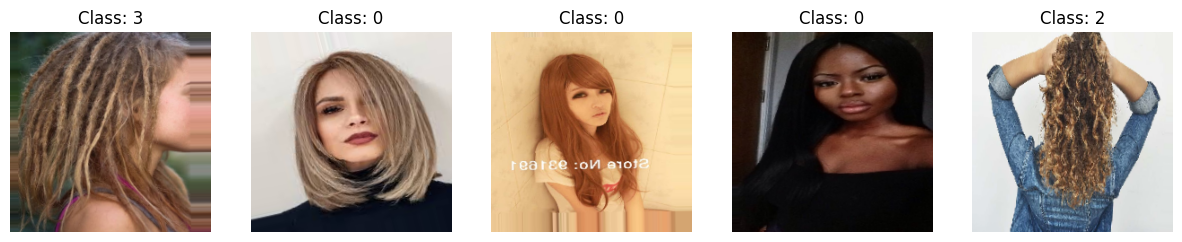

In [ ]:
# Get a batch of images and labels
sample_batch, sample_labels = next(train_generator)

# Display some augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(sample_batch[i])
    axes[i].axis("off")
    axes[i].set_title(f"Class: {int(sample_labels[i])}")

plt.show()

#**Building Custom CNN Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),  # Extra layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),  # More neurons
    Dropout(0.5),
    Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,827,141 (37.49 MB)

 Trainable params: 9,827,141 (37.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import math

steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    class_weight=class_weight_dict,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - accuracy: 0.2427 - loss: 1.6132
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 512ms/step - accuracy: 0.2969 - loss: 1.5715
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 509ms/step - accuracy: 0.3281 - loss: 1.5019
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 506ms/step - accuracy: 0.3640 - loss: 1.4375
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 509ms/step - accuracy: 0.3263 - loss: 1.4334
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 510ms/step - accuracy: 0.4035 - loss: 1.3474
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 513ms/step - accuracy: 0.4555 - loss: 1.2592
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 513ms/step - accuracy: 0.4143 - loss: 1.2848
Epoch 9/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 505ms/step - accuracy: 0.4381 - loss: 1.3147
Epoch 10/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 505ms/step - accuracy: 0.4720 - loss: 1.2133
Epoch 11/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 502ms/step - accuracy: 0.4775 - loss: 1.1791
Epoch 12/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 25

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.7477 - loss: 0.9038
Test Accuracy: 0.7519, Test Loss: 0.7880


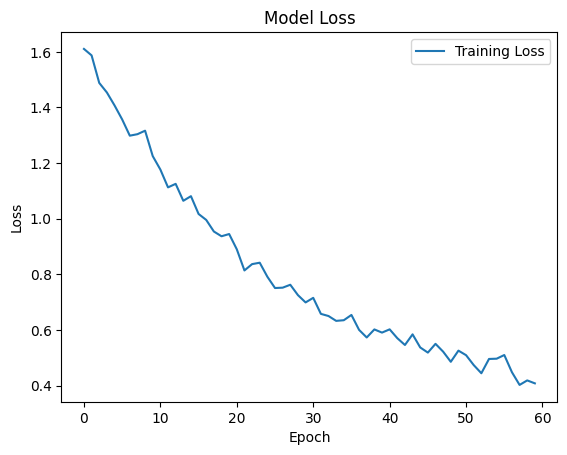

In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step


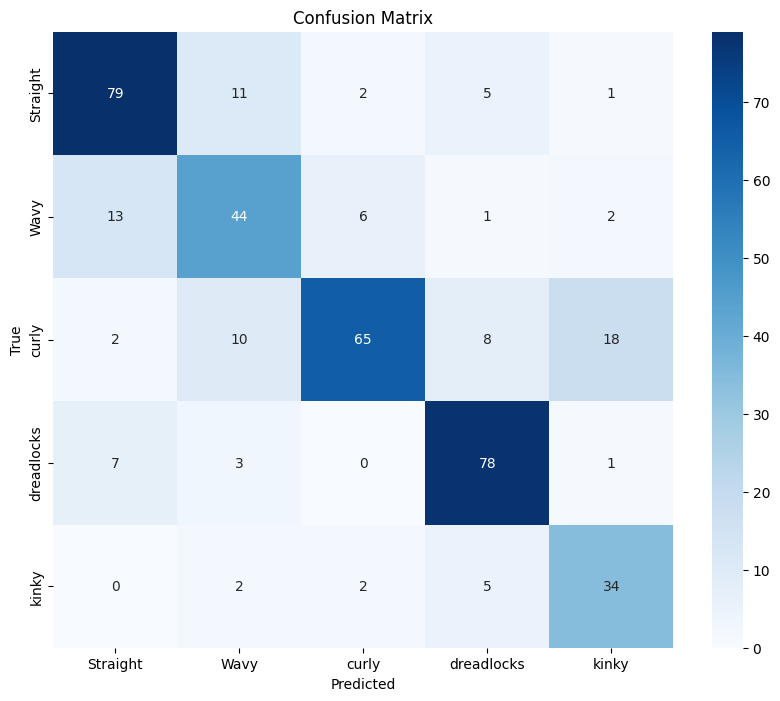

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate predictions on test set
test_generator.reset()  # Reset generator to start from the beginning
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

# Get true classes from test generator
true_classes = test_generator.classes  # Ground truth labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()